# Word Graph

In [1]:
!pip install PyPDF2 nltk networkx pandas matplotlib tqdm
import os, re, math
from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
import PyPDF2
import re
import nltk
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

nltk.download("punkt")  # sekali saja

# --- baca PDF ---
def read_pdf(path):
    pages = []
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for p in reader.pages:
            t = p.extract_text()
            if t:
                pages.append(t)
    return "\n".join(pages)

# GANTI path kalau perlu
pdf_text = read_pdf("kankerparu.pdf")

print("Panjang teks mentah:", len(pdf_text))
print(pdf_text[:500])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Panjang teks mentah: 19894
JOINTER  – JOURNAL OF INFORMATICS ENGINEERING , VOL. 05, NO. 01, JUNI  2024 
Akreditasi Sinta 5 KEMRISTEKDIKBUD No. 225/E/KPT/2022;  E-ISSN 2723 -7958 
 
Dony Bena ya: Implementasi Random Forest  dalam … 27 
Implementasi Random Forest dalam Klasifikasi Kanker Paru -
Paru   
Dony Benaya Dinova1, Budi Prasetiyo2 
1,2 Jurusan Pendidikan Teknik Informatika UNNES  
Email: donybenaya@stundents.unnes.ac. id  
 
 
Abstract— Lung cancer is a serious disease that threatens global health due to its high mo


In [3]:
from nltk.tokenize import word_tokenize

def clean_text(text):
    # buang bagian referensi kalau ada
    cut = re.search(r"(DAFTAR PUSTAKA|REFERENSI|References|Bibliographie)",
                    text, re.IGNORECASE)
    if cut:
        text = text[:cut.start()]
    # rapikan spasi
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned = clean_text(pdf_text)

print("Panjang teks cleaned:", len(cleaned))
print(cleaned[:500])

# --- tokenisasi kata: jaga urutan! ---
tokens = word_tokenize(cleaned.lower())

# ambil hanya huruf (buang angka/tanda baca)
words = [re.sub(r"[^a-zA-Z]", "", w) for w in tokens]
words = [w for w in words if w != ""]  # buang string kosong

print("Total kata:", len(words))
print("20 kata pertama:", words[:20])


Panjang teks cleaned: 19343
JOINTER – JOURNAL OF INFORMATICS ENGINEERING , VOL. 05, NO. 01, JUNI 2024 Akreditasi Sinta 5 KEMRISTEKDIKBUD No. 225/E/KPT/2022; E-ISSN 2723 -7958 Dony Bena ya: Implementasi Random Forest dalam … 27 Implementasi Random Forest dalam Klasifikasi Kanker Paru - Paru Dony Benaya Dinova1, Budi Prasetiyo2 1,2 Jurusan Pendidikan Teknik Informatika UNNES Email: donybenaya@stundents.unnes.ac. id Abstract— Lung cancer is a serious disease that threatens global health due to its high morbidity and mortality
Total kata: 2492
20 kata pertama: ['jointer', 'journal', 'of', 'informatics', 'engineering', 'vol', 'no', 'juni', 'akreditasi', 'sinta', 'kemristekdikbud', 'no', 'ekpt', 'eissn', 'dony', 'bena', 'ya', 'implementasi', 'random', 'forest']


In [4]:
from itertools import zip_longest

G = nx.Graph()

# tambahkan node
for w in words:
    if not G.has_node(w):
        G.add_node(w)

# tambahkan edge untuk pasangan bertetangga (distance = 1)
for w1, w2 in zip(words, words[1:]):
    if w1 == "" or w2 == "":
        continue
    if G.has_edge(w1, w2):
        # boleh pakai weight kalau mau tahu seberapa sering
        G[w1][w2]["weight"] += 1
    else:
        G.add_edge(w1, w2, weight=1)

print("Jumlah node (kata unik):", G.number_of_nodes())
print("Jumlah edge (pasangan tetangga):", G.number_of_edges())


Jumlah node (kata unik): 870
Jumlah edge (pasangan tetangga): 1954


In [5]:
from collections import Counter

# hitung frekuensi kata untuk pilih N terbesar
freq = Counter(words)
N = 20   # ubah kalau mau 30 / 50 kata, dsb

# ambil N kata paling sering
top_vocab = [w for w, c in freq.most_common(N)]
print("Kata yang dipakai di matriks:", top_vocab)

# buat indeks
idx = {w: i for i, w in enumerate(top_vocab)}

# inisialisasi matriks 0
A = np.zeros((N, N), dtype=int)

# isi matriks: kalau ada edge di graph → 1
for u, v in G.edges():
    if u in idx and v in idx:
        i, j = idx[u], idx[v]
        A[i, j] = 1
        A[j, i] = 1   # graph tak berarah

adj_df = pd.DataFrame(A, index=top_vocab, columns=top_vocab)
adj_df


Kata yang dipakai di matriks: ['yang', 'paru', 'dalam', 'data', 'dan', 'untuk', 'kanker', 'dengan', 'ini', 'random', 'forest', 'model', 'and', 'metode', 'no', 'menggunakan', 'pada', 'dapat', 'dari', 'kelas']


,yang,paru,dalam,data,dan,untuk,kanker,dengan,ini,random,forest,model,and,metode,no,menggunakan,pada,dapat,dari,kelas
yang,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1
paru,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0
dalam,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
data,1,0,1,0,1,1,1,1,1,0,0,1,0,1,0,1,1,0,1,1
dan,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0
untuk,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0,1
kanker,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
dengan,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
ini,0,0,0,1,0,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0
random,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0


In [6]:
pr = nx.pagerank(G, weight="weight")  # pakai bobot berapa sering jadi tetangga

# urutkan dari yang terbesar
pr_sorted = sorted(pr.items(), key=lambda x: x[1], reverse=True)

# tampilkan 20 kata terpenting
top_pr = pr_sorted[:20]
pr_df = pd.DataFrame(top_pr, columns=["Kata", "PageRank"])
pr_df


,Kata,PageRank
0,yang,0.027061
1,data,0.015956
2,dalam,0.015310
3,dan,0.014433
4,untuk,0.014286
5,paru,0.014079
6,dengan,0.012080
7,and,0.010830
8,ini,0.010506
9,kanker,0.010496


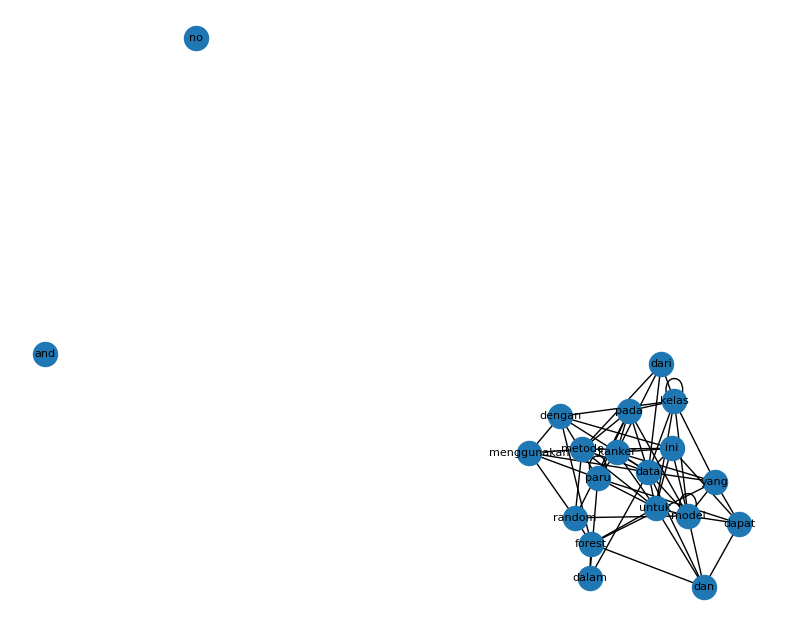

In [7]:
plt.figure(figsize=(10, 8))

subG = G.subgraph(top_vocab)
pos = nx.spring_layout(subG, k=0.4)

nx.draw_networkx_nodes(subG, pos)
nx.draw_networkx_edges(subG, pos)
nx.draw_networkx_labels(subG, pos, font_size=8)

plt.axis("off")
plt.show()
